In [1]:
import pandas as pd 
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os


os.chdir('../Dataset')
path = os.getcwd()

columns = ['class','l_shoulder','r_shoulder','l_arm','r_arm','l_hip','r_hip','l_knee','r_knee']

Y82_test = pd.read_csv(os.path.join(path,'Y82_testing_new.csv'), header=None)
Y82_train = pd.read_csv(os.path.join(path,'Y82_training_new.csv'), header=None)

L_test = pd.read_csv(os.path.join(path,'L_testing_new.csv'), header=None)
L_train = pd.read_csv(os.path.join(path,'L_training_new.csv'), header=None)

W2_test = pd.read_csv(os.path.join(path,'W2_testing_new.csv'), header=None)
W2_train = pd.read_csv(os.path.join(path,'W2_training_new.csv'), header=None)

Neutral_test = pd.read_csv(os.path.join(path,'Neutral_testing.csv'), header=None)
Neutral_train = pd.read_csv(os.path.join(path,'Neutral_training.csv'), header=None) 

combined_test = pd.concat([L_test, Y82_test, W2_test, Neutral_test])
combined_train = pd.concat([L_train, Y82_train, W2_train, Neutral_train])

combined_test.columns = columns 
combined_train.columns = columns 

combined_test['class'], classes = pd.factorize(combined_test['class'])
combined_train['class'], _ = pd.factorize(combined_train['class'])

''' Filtering out all the extra examples for the cobra class to make a more balanced data set '''
extra_test_cobra_rows = combined_test[combined_test['class'] == 1].sample(130)
extra_train_cobra_rows = combined_train[combined_train['class'] == 1].sample(275)

combined_test = combined_test.drop(extra_test_cobra_rows.index)
combined_train = combined_train.drop(extra_train_cobra_rows.index)

classes = list(classes)

In [2]:
for i, c in enumerate(classes):
    print(f"Train: {c} - {len(combined_train[combined_train['class'] == i])}")
    print(f"Test: {c} - {len(combined_test[combined_test['class'] == i])}")
    print()

Train: Tree - 368
Test: Tree - 109

Train: Cobra - 318
Test: Cobra - 128

Train: Chair - 321
Test: Chair - 141

Train: DownDog - 282
Test: DownDog - 97

Train: WarriorII - 382
Test: WarriorII - 140

Train: Neutral - 221
Test: Neutral - 54



In [3]:
all_combined_df = pd.concat([Y82_train, Y82_test, L_test, L_train, W2_train, W2_test])
all_combined = pd.concat([combined_test, combined_train])

def split_features_labels(df):
    return df.drop('class', axis=1), df['class']

# Random Forest Classifer
# 88-89% Maybe 90?
## IDK anymore.. even this is at like 95% lol

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       109
           1       0.90      0.94      0.92       119
           2       0.93      0.90      0.92       141
           3       0.98      0.96      0.97        98
           4       0.95      0.98      0.96       139
           5       0.76      0.72      0.74        53

    accuracy                           0.93       659
   macro avg       0.92      0.91      0.91       659
weighted avg       0.93      0.93      0.93       659



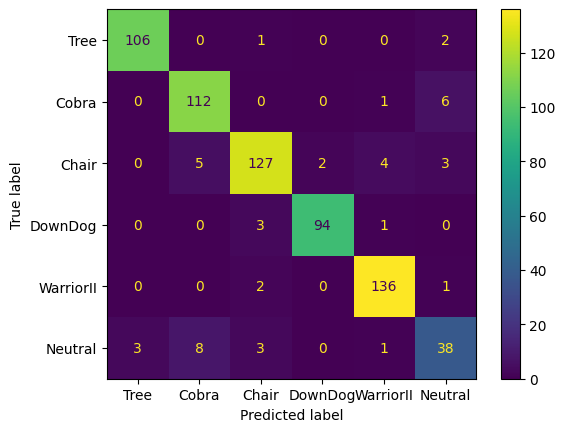

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import train_test_split // Don't need anymore

RANDOM_ORDER_DATA = True 
MAX_ESTIMATORS = 100
MAX_DEPTH = 8 

if RANDOM_ORDER_DATA:
  mutated_train = combined_train.sample(frac=1)
else:
  mutated_train = combined_train

X_train, y_train = split_features_labels(mutated_train)
X_test, y_test = split_features_labels(combined_test)


forest_classifier = RandomForestClassifier()
param_grid = {'n_estimators' : np.arange(1, MAX_ESTIMATORS),
              'max_depth' : np.arange(1, MAX_DEPTH),
            }

forest_classifier_gscv = RandomizedSearchCV(forest_classifier, param_distributions=param_grid, cv=5, n_jobs=-1)

#fit model to data
forest_classifier_gscv.fit(X_train, y_train)

MAX_DEPTH = forest_classifier_gscv.best_params_['max_depth']
N_ESTIMATORS = forest_classifier_gscv.best_params_['n_estimators']

best_forest = RandomForestClassifier(max_depth=MAX_DEPTH, n_estimators=N_ESTIMATORS)
best_forest.fit(X_train, y_train)

pred = best_forest.predict(X_test)
cm = confusion_matrix(y_test, pred)
display_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
display_confusion_matrix.plot()
print(classification_report(y_test, pred))

# KNN Classifer 
# Eh Around 88%


Fitted KNN Classifer with ALGORITHM='kd_tree' and N_NEIGHBORS=3
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       113
           1       0.96      0.95      0.95       118
           2       0.96      0.92      0.94       141
           3       0.99      0.98      0.98        98
           4       0.97      0.97      0.97       140

    accuracy                           0.96       610
   macro avg       0.96      0.96      0.96       610
weighted avg       0.96      0.96      0.96       610



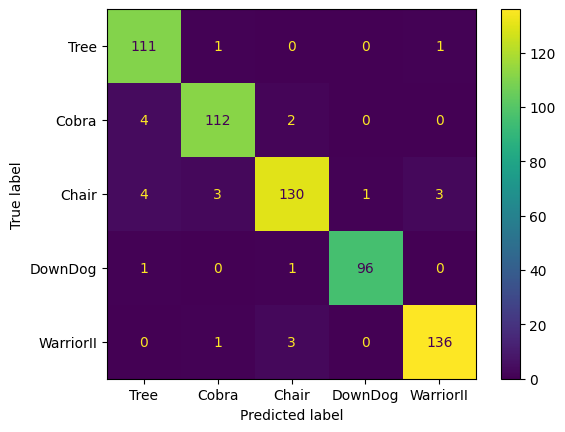

In [12]:
# Grid searching best hyper params 
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as KNN 

''' Don't need to do this anymore, cause the dataset is already split (Didn't realise this) '''
# from sklearn.model_selection import train_test_split
# 80/20 Split of data, Doesn't randomize, Randomsplit ensures the proportion of classes is the same. 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
RANDOM_ORDER_DATA = True 



'''Shuffle data for better resuliting'''
if RANDOM_ORDER_DATA:
    mutated_train = combined_train.sample(frac=1)
else:
    mutated_train = combined_train

X_train, y_train = split_features_labels(mutated_train)
X_test, y_test = split_features_labels(combined_test)

max_neighbours = int(np.sqrt(len(X_train)))
knn_algorithms = ['kd_tree', 'brute', 'ball_tree']


knn = KNN()

param_grid = {'n_neighbors' : np.arange(1, max_neighbours),
              'algorithm' : knn_algorithms}

# Using grid search cross validation to find the best value of K 
knn_gscv = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1)

knn_gscv.fit(X_train, y_train)

ALGORITHM = knn_gscv.best_params_['algorithm']
N_NEIGHBORS = knn_gscv.best_params_['n_neighbors']

best_KNN = KNN(algorithm=ALGORITHM, n_neighbors=N_NEIGHBORS)
best_KNN.fit(X_train, y_train)

print(f"Fitted KNN Classifer with {ALGORITHM=} and {N_NEIGHBORS=}")


pred = best_KNN.predict(X_test)
cm = confusion_matrix(y_test, pred)
display_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
display_confusion_matrix.plot()
print(classification_report(y_test, pred))

# NN Classifier
## About 87-89% Acc - okay
## WOW WITH JUST A BIT OF DATACLEANING, GETTING SOME MORE EXAMPLES AND FIXING A BUG THE ACCURACY SHOT UP - 94% 

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

GRID_SEARCH_PARAMS = False


'''Shuffle data for better resuliting'''
RANDOM_ORDER_DATA = True 
if RANDOM_ORDER_DATA:
    mutated_train = combined_train.sample(frac=1)
else:
    mutated_train = combined_train

X_train, y_train = split_features_labels(mutated_train)
X_test, y_test = split_features_labels(combined_test)

# Define the parameter distributions to sample from
param_dist = {
    'hidden_layer_sizes' : [(i, j) for i in range(1, 15) for j in range(1, 15)],
    'solver': ['adam', 'lbfgs'],
    'activation': ['relu', 'logistic'],
    'alpha' : [0.0001, 0.0001, 0.00005]
}

# Initialize MLPClassifier with default values
mlp = MLPClassifier(max_iter=1000)

if GRID_SEARCH_PARAMS:
    random_search = RandomizedSearchCV(mlp, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1)

    # Train the classifier on your data
    random_search.fit(X_train, y_train)

    # Get the best hyperparameters from the search
    best_params = random_search.best_params_
    print("Best solver: ", best_params['solver'])
    print("Best activation: ", best_params['activation'])
    print("Layers: ", best_params['hidden_layer_sizes'] )
    print("Alpha: ", best_params['alpha'])

    # Use the best hyperparameters to initialize the MLPClassifier
    best_mlp = MLPClassifier(solver=best_params['solver'], activation=best_params['activation'], alpha=best_params['alpha'], hidden_layer_sizes=best_params['hidden_layer_sizes'], max_iter=1000)

    # Train the MLPClassifier on the training data
    best_mlp.fit(X_train, y_train)
else:
    ''' If you want to skip searching for params. Train NN with values:
    solver: adam
    activation: relu
    layers: 11, 14
    alpha: 0.0001
    '''
    best_mlp = MLPClassifier(solver='adam', activation='relu', alpha=0.0001, hidden_layer_sizes=(11, 14), max_iter=1000)
    best_mlp.fit(X_train, y_train)


In [7]:
print("Best solver: ", best_params['solver'])
print("Best activation: ", best_params['activation'])
print("Layers: ", best_params['hidden_layer_sizes'] )
print("Alpha: ", best_params['alpha'])

Best solver:  adam
Best activation:  logistic
Layers:  (14, 6)
Alpha:  0.0001


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       109
           1       0.93      0.83      0.88       119
           2       0.93      0.88      0.91       141
           3       0.98      0.92      0.95        98
           4       0.88      0.97      0.92       139
           5       0.70      0.83      0.76        53

    accuracy                           0.91       659
   macro avg       0.90      0.90      0.90       659
weighted avg       0.91      0.91      0.91       659



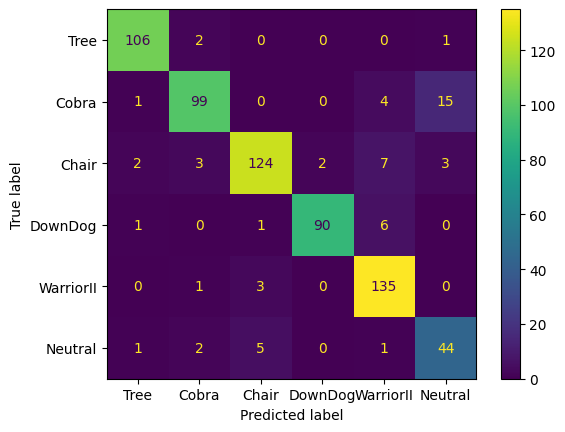

In [7]:
# # Use the best hyperparameters to initialize the MLPClassifier
# best_mlp = MLPClassifier(solver=best_params['solver'], activation=best_params['activation'], alpha=best_params['alpha'], hidden_layer_sizes=best_params['hidden_layer_sizes'], max_iter=1000)

# # Train the MLPClassifier on the training data
# best_mlp.fit(X_train, y_train)

pred = best_mlp.predict(X_test)
cm = confusion_matrix(y_test, pred)
display_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
display_confusion_matrix.plot()
print(classification_report(y_test, pred))

# SVC Grid Search Classifer
## Consistent 90% Sometimes 91%
## After replacing Warrior3 for Warrior2 (Is a hard pose to do, and W3 had too much overlap with the other classes + fixing a 20degree error in the pre-processing the accuracy gained went up by 5% !!)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'C': 10, 'gamma': 'scale'}
Best Score:  0.9143834373385824
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       109
           1       0.89      0.91      0.90       128
           2       0.92      0.92      0.92       141
           3       0.98      0.98      0.98        97
           4       0.94      0.97      0.96       140
           5       0.72      0.67      0.69        54

    accuracy                           0.92       669
   macro avg       0.91      0.90      0.90       669
weighted avg       0.92      0.92      0.92       669



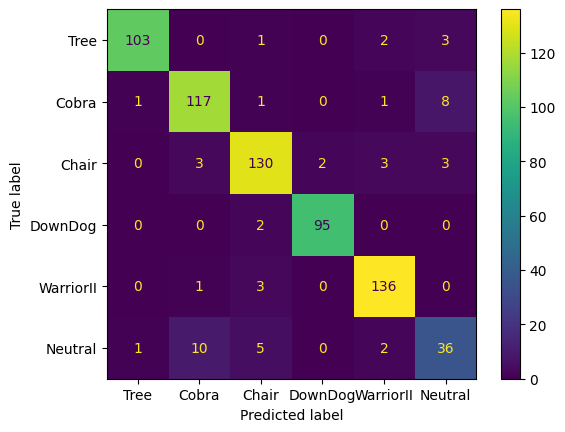

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.svm import SVC

RANDOM_ORDER_DATA = True 
RANDOM_CV = False

'''Shuffle data for better resuliting'''
if RANDOM_ORDER_DATA:
    mutated_train = combined_train.sample(frac=1)
else:
    mutated_train = combined_train

X_train, y_train = split_features_labels(mutated_train)
X_test, y_test = split_features_labels(combined_test)

svm = SVC(kernel='rbf') 


'''Tried search for gamma manually but it appears using scale is just better''' 
n_features = X_train.shape[1]
gamma_start = 1 / (n_features * max(X_train.var()))
gamma_step = 0.005
gamma_end = gamma_start + (10 * gamma_step)

### Doing Grid Search Now ###

gamma_range = np.arange(gamma_start, gamma_end, gamma_step)
C_range = [0.1, 1, 5, 10]
# set the parameter grid for grid search
param_grid = {
        'C': C_range,
        'gamma' : ['scale']
    }

# perform grid search
if RANDOM_CV:
    grid = RandomizedSearchCV(svm, cv=5, param_distributions=param_grid, verbose=1)
else:
    grid = GridSearchCV(svm, cv=5, param_grid=param_grid, verbose=1)
grid.fit(X_train, y_train)

# best parameters and score
print("Best parameters:", grid.best_params_)
print("Best Score: ", grid.best_score_)

best_svc = SVC(kernel='rbf', C=grid.best_params_['C'], gamma=grid.best_params_['gamma'], probability=True)

best_svc.fit(X_train, y_train)

''' Plotting '''

pred = best_svc.predict(X_test)
cm = confusion_matrix(y_test, pred)
display_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
display_confusion_matrix.plot()
print(classification_report(y_test, pred))

# Video & Classifer Integration

In [5]:
import cv2
import mediapipe as mp
import numpy as np
import time 

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

MIN_DETECTION_CONFIDENCE = 0.5
MIN_TRACKING_CONFIDENCE = 0.5

# All landmark except for hand and face specific
RelevantLandmarks = list(mp_pose.PoseLandmark)[11:17] + list(mp_pose.PoseLandmark)[23:29]

l_hip_landmark_angle_idx = (11,23,25)
r_hip_landmark_angle_idx = (12,24,26)

l_shoulder_landmark_angle_idx = (13,11,23)
r_shoulder_landmark_angle_idx = (14,12,24)

l_arm_landmark_angle_idx = (15,13,11)
r_arm_landmark_angle_idx = (16,14,12)

l_knee_landmark_angle_idx = (23,25,27)
r_knee_landmark_angle_idx = (24,26,28)

#Match idx of RelevantLandmarks 
angle_idxs_required = [
    l_shoulder_landmark_angle_idx,
    r_shoulder_landmark_angle_idx,
    
    l_arm_landmark_angle_idx,
    r_arm_landmark_angle_idx,
    
    l_hip_landmark_angle_idx,
    r_hip_landmark_angle_idx,
    
    l_knee_landmark_angle_idx,
    r_knee_landmark_angle_idx
]
skip_landmark = {
    mp_pose.PoseLandmark.RIGHT_ANKLE,
    mp_pose.PoseLandmark.LEFT_ANKLE,
    mp_pose.PoseLandmark.RIGHT_WRIST,
    mp_pose.PoseLandmark.LEFT_WRIST
}

In [6]:
landmarkStr = {
    mp_pose.PoseLandmark.NOSE : "NOSE",
    mp_pose.PoseLandmark.LEFT_EYE_INNER : "LEFT_EYE_INNER",
    mp_pose.PoseLandmark.LEFT_EYE : "LEFT_EYE",
    mp_pose.PoseLandmark.LEFT_EYE_OUTER : "LEFT_EYE_OUTER",
    mp_pose.PoseLandmark.RIGHT_EYE_INNER : "RIGHT_EYE_INNER",
    mp_pose.PoseLandmark.RIGHT_EYE : "RIGHT_EYE",
    mp_pose.PoseLandmark.RIGHT_EYE_OUTER : "RIGHT_EYE_OUTER",
    mp_pose.PoseLandmark.LEFT_EAR : "LEFT_EAR",
    mp_pose.PoseLandmark.RIGHT_EAR : "RIGHT_EAR",
    mp_pose.PoseLandmark.MOUTH_LEFT : "MOUTH_LEFT",
    mp_pose.PoseLandmark.MOUTH_RIGHT : "MOUTH_RIGHT",
    mp_pose.PoseLandmark.LEFT_SHOULDER : "LEFT_SHOULDER",
    mp_pose.PoseLandmark.RIGHT_SHOULDER : "RIGHT_SHOULDER",
    mp_pose.PoseLandmark.LEFT_ELBOW : "LEFT_ELBOW",
    mp_pose.PoseLandmark.RIGHT_ELBOW : "RIGHT_ELBOW",
    mp_pose.PoseLandmark.LEFT_WRIST : "LEFT_WRIST",
    mp_pose.PoseLandmark.RIGHT_WRIST : "RIGHT_WRIST",
    mp_pose.PoseLandmark.LEFT_PINKY : "LEFT_PINKY",
    mp_pose.PoseLandmark.RIGHT_PINKY : "RIGHT_PINKY",
    mp_pose.PoseLandmark.LEFT_INDEX : "LEFT_INDEX",
    mp_pose.PoseLandmark.RIGHT_INDEX : "RIGHT_INDEX",
    mp_pose.PoseLandmark.LEFT_THUMB : "LEFT_THUMB",
    mp_pose.PoseLandmark.RIGHT_THUMB : "RIGHT_THUMB",
    mp_pose.PoseLandmark.LEFT_HIP : "LEFT_HIP",
    mp_pose.PoseLandmark.RIGHT_HIP : "RIGHT_HIP",
    mp_pose.PoseLandmark.LEFT_KNEE : "LEFT_KNEE",
    mp_pose.PoseLandmark.RIGHT_KNEE : "RIGHT_KNEE",
    mp_pose.PoseLandmark.LEFT_ANKLE : "LEFT_ANKLE",
    mp_pose.PoseLandmark.RIGHT_ANKLE : "RIGHT_ANKLE",
    mp_pose.PoseLandmark.LEFT_HEEL : "LEFT_HEEL",
    mp_pose.PoseLandmark.RIGHT_HEEL : "RIGHT_HEEL",
    mp_pose.PoseLandmark.LEFT_FOOT_INDEX : "LEFT_FOOT_INDEX",
    mp_pose.PoseLandmark.RIGHT_FOOT_INDEX : "RIGHT_FOOT_INDEX"
}

def calc_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)    
    c = np.array(c)   
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle > 180.0:
        angle = 360-angle
    
    return angle 

In [7]:
def classify_pose(example, classifer):
    example = pd.DataFrame(np.array(example).reshape(1, -1), columns=columns[1:])

    if classifer == 'KNN':
        probabilty_classes = best_KNN.predict_proba(example)
    elif classifer == 'Forest':
        probabilty_classes = best_forest.predict_proba(example)
    elif classifer == 'SVM':
        probabilty_classes = best_svc.predict_proba(example)
    elif classifer == 'NN':
        probabilty_classes = best_mlp.predict_proba(example)
    else:
        raise Exception("Please enter valid classifer. Currently only ('KNN' | 'Forest' | 'NN' | 'SVM')")

    
    prob_predicted_classes = [] 
    for class_idx, prob in enumerate(probabilty_classes[0]):
        prob_predicted_classes.append((classes[class_idx], prob))
        
    prob_predicted_classes.sort(key = lambda x: x[1], reverse=True)
    
    # Get the highest predicted class 
    predicted_class = prob_predicted_classes[0]
    
    return (predicted_class[0], predicted_class[1], sorted(prob_predicted_classes, key = lambda x: x[1], reverse=True))

# Sanity test classification 
classify_pose([8.390697637127042, 13.364568331384618, 16.49759248897499, 153.50000646379374, 173.20291493738577, 199.52935190007366, 179.00845878279233, 198.25172013734928], classifer='SVM')

('Neutral',
 0.7392457773912511,
 [('Neutral', 0.7392457773912511),
  ('Cobra', 0.12725626335455595),
  ('WarriorII', 0.061524294489475696),
  ('DownDog', 0.03160161727155574),
  ('Tree', 0.020689097815404827),
  ('Chair', 0.01968294967775652)])

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X_train_pca = pca.fit_transform(X_train)

def extract_pca_2d(example):
    example = pd.DataFrame(np.array(example).reshape(1, -1), columns=columns[1:])
    return pca.transform(example)

In [9]:
def unnormalize_cords(x, y, fw, fh):
    return tuple(np.multiply([x, y], [fw, fh]).astype(int))

In [11]:
# This is just storing each frame in a real life demonstration as a projected point in 2D using pca 
# Which then decision boundaries will be plotted of the SVM model used to determin how someone moves around in a real life example
PCA_2D_POINTS = [] 

# Getting the ideal angles into a dataframe
## Currently the method just gets the ideal images and finds the angles in those images and uses that as the ideal example.
## A more sophisiticated method may be getting a large amount of ideal examples and averaging over all of their angles to get a mean ideal angle for each key point. Ideal

In [13]:
ideal_angles = pd.read_csv('../DemoImages/Ideal_Angles.csv', header=None)
ideal_angles.columns = columns 

''' Need to alter this since WarriorII can be looking LEFT or RIGHT -- Must add another ideal angles value'''
ideal_angles_map = {pose : ideal_angles[ideal_angles['class'] == pose].values[0][1:] for pose in classes}
ideal_angles_map

{'Tree': array([10.95475, 15.08657, 28.13875, 28.80628, 129.95217, 178.40344,
        46.07454, 178.07962], dtype=object),
 'Cobra': array([8.0191, 4.79425, 153.93274, 142.10419, 122.97457, 124.22521,
        170.49025, 165.01964], dtype=object),
 'Chair': array([170.9008, 168.49341, 168.75209, 166.47359, 128.21184, 127.42096,
        143.55099, 140.59207], dtype=object),
 'DownDog': array([169.85176, 166.94317, 172.9461, 168.72256, 47.17155, 45.9781,
        179.13111, 178.03683], dtype=object),
 'WarriorII': array([98.57816, 84.57546, 172.71366, 167.60448, 100.42109, 144.27339,
        111.14634, 172.4303], dtype=object),
 'Neutral': array([40.50407, 18.58808, 10.78455, 164.96146, 172.57595, 169.32033,
        176.94879, 178.26653], dtype=object)}

# Caluclate the total score of a users score. Currently using trivial MSE -- will get more sophisitcated as development continues 

In [14]:
def calculate_pose_score(ideal_example, user_example):

    tot = 0 
    for x in zip(ideal_example, user_example):

        tmp_score = 100 * (1 - (np.abs((x[0] - x[1]))/360))
        tot += tmp_score
        print(tmp_score)
    
    print(tot//len(ideal_example))

''' Using Cosine Similarty Method
Convert the two lists of angles into numpy arrays, and then we calculate the dot product of the two arrays and divide it by the product of their norms. 
This gives us the cosine similarity. Finally, we return a score between 0 and 100 by adding 1 to the cosine similarity and multiplying it by 50. 
The result will be a number between 0 and 100, where 100 indicates that the vectors are identical and 0 indicates that the vectors are completely dissimilar.'''
def calculate_pose_score(current_ideal_angles, pose_relevant_landmark_angles):
    current_ideal_angles = np.array(current_ideal_angles)
    pose_relevant_landmark_angles = np.array(pose_relevant_landmark_angles)

    cos_sim = np.dot(current_ideal_angles, pose_relevant_landmark_angles) / (np.linalg.norm(current_ideal_angles) * np.linalg.norm(pose_relevant_landmark_angles))

    return ((cos_sim + 1) * 50)/100

    # return sum((x[0] - x[1])**2 for x in zip(ideal_example, user_example))

calculate_pose_score(ideal_angles_map['Neutral'], [101.83062,105.14425,179.29316,165.91826,149.00613,120.46648,161.93572,125.21185])

0.9267102129259095

# Main video / classification loop

In [203]:
CLASSIFIER = 'SVM'
import traceback

# Create two windows to display the images
# cv2.namedWindow("Real Image", cv2.WINDOW_NORMAL)
# cv2.namedWindow("Pose Skeleton", cv2.WINDOW_NORMAL)
last_class = ''
MIN_DETECTION_CONFIDENCE = 0.5
MIN_TRACKING_CONFIDENCE = 0.5
VERBOSE = False
EXAMPLE_POSE_IMAGE = {i.replace('.jpeg', '') : cv2.imread(f"../DemoImages/{i}", 1) for i in os.listdir("../DemoImages")}


''' Using the media pose model'''
with mp_pose.Pose(min_detection_confidence=MIN_DETECTION_CONFIDENCE, min_tracking_confidence=MIN_TRACKING_CONFIDENCE, static_image_mode=False) as pose:
    '''
        Capturing webcam footage 
    '''
    cap = cv2.VideoCapture(0) # this is the magic!

    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    while cap.isOpened():
        suc, frame = cap.read() 
        if not suc:
            print("Frame empty..")
            continue 
        
        #Recolor image 
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        try: 
            # Make detections 
            results = pose.process(image=image)
            pose_landmarks = results.pose_landmarks

            ''' Converting landmarks into angles'''
            pose_relevant_landmark_angles = []
            # Going through all relevant landmarks, extracting their key angles
            # Calculating the angle then adding to array 
            for i1, i2, i3 in angle_idxs_required:
                
                fst = (pose_landmarks.landmark[i1].x, pose_landmarks.landmark[i1].y)
                snd = (pose_landmarks.landmark[i2].x, pose_landmarks.landmark[i2].y)
                thrd = (pose_landmarks.landmark[i3].x, pose_landmarks.landmark[i3].y)
                
                
                pose_relevant_landmark_angles.append(calc_angle(fst, snd, thrd))
                
            # Getting cords of the landmarks FOR ANGLES WE CALC'D CORDS FOR. 
            # If any any of this landamrks have a visbility < MIN_DETECTION_CONFIDENCE. 
            # Display an error / throw an error saying you need the whole body in the frame
            pose_relevant_landmark_cords = [] 
            for _, idx, _ in angle_idxs_required:
                if idx in skip_landmark:
                    continue
                
                current_landmark = pose_landmarks.landmark[idx]
                
                pose_relevant_landmark_cords.append([current_landmark.x, current_landmark.y])
                
            
            pose_relevant_landmark_angles_visual = np.around(pose_relevant_landmark_angles, 2).astype(str).tolist()
            
            ''' CLASSIFICATION OF POSE''' 
            predicted_proba_pose, prob_predictions = classify_pose(pose_relevant_landmark_angles, CLASSIFIER)

            predicted_pose = predicted_proba_pose[0]
            predicted_pose_confidence = predicted_proba_pose[1]

            current_ideal_angles = ideal_angles_map[predicted_pose]
            
            user_score = calculate_pose_score(current_ideal_angles, pose_relevant_landmark_angles)

            ''' Extracting 2D PCA Points -- Not ready for changing currently'''
            tmp_2d_example = pose_relevant_landmark_angles_visual
            tmp_class = predicted_pose
            PCA_2D_POINTS.append((tmp_2d_example, tmp_class))
            
            ''' Pose Threshold'''

            if (predicted_pose_confidence >= 0.80):
                if last_class != predicted_pose:
                    last_class = predicted_pose
                    if VERBOSE:
                        print(predicted_pose)
            else:
                if last_class != 'Neutral':
                    last_class = 'Neutral'
                    if VERBOSE:
                        print("No Pose Detected")
                        
                if VERBOSE:
                    print(f'PROBAS: {prob_predictions}')

            ''' First Window '''
            #Revert image color 
            image.flags.writeable = True 
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            #Render detections 
            mp_drawing.draw_landmarks(
                image, 
                results.pose_landmarks, 
                mp_pose.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(50, 145, 168), circle_radius=2, thickness=2),
                mp_drawing.DrawingSpec(color=(209, 192, 42), circle_radius=2, thickness=2)
            )
            
            if last_class == 'Neutral':
                display_text = 'Neutral'
            else:
                display_text = f'{last_class} - {predicted_pose_confidence*100:.2f}%'
            
            cv2.putText(image, display_text, unnormalize_cords(0.4, 0.1, frame_width, frame_height), cv2.FONT_HERSHEY_SIMPLEX, 2, (125, 0, 0), 2, cv2.LINE_AA) 
            ''' ---- '''
            
            ''' Second Window '''
            black_image = np.zeros((frame_height, frame_width, 3), np.uint8)

            # Render detections on the black image
            mp_drawing.draw_landmarks(
                black_image, 
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,                
                mp_drawing.DrawingSpec(color=(50, 145, 168), circle_radius=2, thickness=2),
                mp_drawing.DrawingSpec(color=(209, 192, 42), circle_radius=2, thickness=2)
            )

            
            # Write the joint angles on the black image
            for i, angle in enumerate(pose_relevant_landmark_angles_visual):
                x, y = pose_relevant_landmark_cords[i]
                cv2.putText(black_image, angle, unnormalize_cords(x, y, frame_width, frame_height), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
            
            # Display the filled rectangle
            rectangle_height = int(frame_height * user_score)
            cv2.rectangle(black_image, (0, frame_height - rectangle_height), (100, frame_height), (0, 0, 255), -1)
            ''' ---- '''
            
            ''' Third Window '''
            correct_example_image = cv2.resize(EXAMPLE_POSE_IMAGE[last_class], (frame_width, frame_height))            
            ''' ---- '''
                        
            # Display the two images side by side
            result = np.concatenate((image, black_image, correct_example_image), axis=1)
            
            cv2.imshow("Image & Skele", result)

        except Exception:
            # print('Exception Caught:')
            traceback.print_exc()
            continue

        # Closing the video capture  
        if cv2.waitKey(1) & 0xFF == ord('w'):
            break
    
    
cap.release() 
cv2.destroyAllWindows()

Traceback (most recent call last):
  File "/var/folders/0w/frp33_5n4pgd72mq7p28n8p00000gn/T/ipykernel_50605/3472387324.py", line 38, in <module>
    joint_angles, joint_angles_rounded = extract_joint_angles(image, pose)
  File "/var/folders/0w/frp33_5n4pgd72mq7p28n8p00000gn/T/ipykernel_50605/606181558.py", line 32, in extract_joint_angles
    fst = (pose_landmarks.landmark[i1].x, pose_landmarks.landmark[i1].y)
AttributeError: 'NoneType' object has no attribute 'landmark'
Traceback (most recent call last):
  File "/var/folders/0w/frp33_5n4pgd72mq7p28n8p00000gn/T/ipykernel_50605/3472387324.py", line 38, in <module>
    joint_angles, joint_angles_rounded = extract_joint_angles(image, pose)
  File "/var/folders/0w/frp33_5n4pgd72mq7p28n8p00000gn/T/ipykernel_50605/606181558.py", line 32, in extract_joint_angles
    fst = (pose_landmarks.landmark[i1].x, pose_landmarks.landmark[i1].y)
AttributeError: 'NoneType' object has no attribute 'landmark'
Traceback (most recent call last):
  File "/var/

KeyboardInterrupt: 

In [192]:
PCA_2D_POINTS #Keep this here for testing. Don't change this variable

[(['68.94', '46.86', '179.15', '133.34', '106.58', '170.63', '86.4', '171.58'],
  'WarriorII'),
 (['12.52', '4.49', '127.56', '171.2', '172.31', '166.02', '158.41', '165.21'],
  'Neutral'),
 (['7.69', '5.37', '34.55', '176.17', '178.39', '166.68', '159.16', '164.38'],
  'Neutral'),
 (['6.07', '9.58', '30.8', '171.38', '173.45', '169.76', '165.86', '162.74'],
  'Neutral'),
 (['4.34', '8.6', '34.92', '165.59', '172.49', '170.1', '170.63', '168.88'],
  'Neutral'),
 (['4.41', '9.4', '29.79', '165.96', '168.42', '174.64', '165.39', '174.67'],
  'Neutral'),
 (['3.34', '9.31', '28.19', '167.93', '167.84', '176.42', '166.41', '174.83'],
  'Neutral'),
 (['1.1', '9.26', '30.84', '173.28', '171.16', '177.1', '166.92', '177.0'],
  'Neutral'),
 (['3.53', '9.32', '26.71', '176.2', '169.29', '171.55', '164.3', '169.73'],
  'Neutral'),
 (['0.95', '6.78', '26.82', '179.26', '175.53', '174.06', '170.35', '167.78'],
  'Neutral'),
 (['1.08', '5.41', '30.39', '179.36', '176.64', '171.34', '171.53', '164.93

# Plotting the scatter plot of the last ran test on a real person using the application

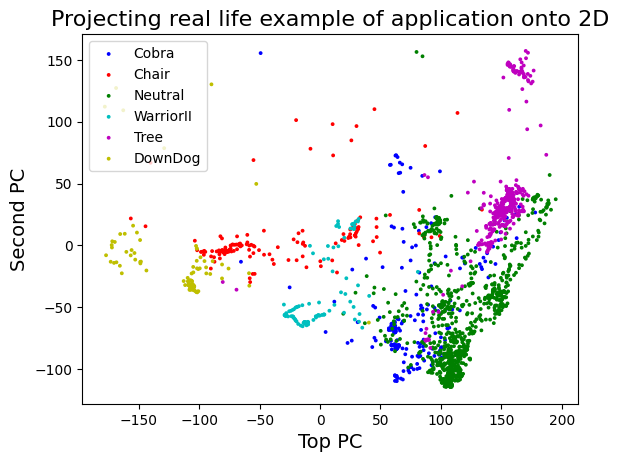

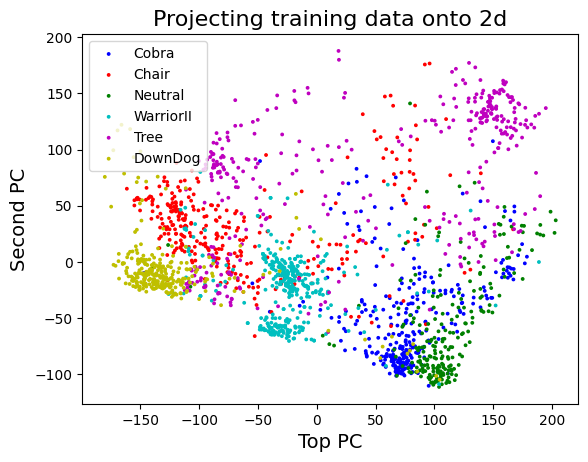

In [193]:
import matplotlib.pyplot as plt 


def plot_2d_projection(points, real):
    cords = [(extract_pca_2d(x[0]), x[1]) for x in points]

    class_labels = [point[1] for point in cords]

    unique_classes = set(class_labels)
    colors = {class_label: index for index, class_label in enumerate(unique_classes)}
    mat_colors = ['b', 'r', 'g', 'c', 'm', 'y']


    fig, ax = plt.subplots()

    for class_label in unique_classes:
        x_v = [point[0][0][0] for idx, point in enumerate(cords) if class_labels[idx] == class_label]
        y_v = [point[0][0][1] for idx, point in enumerate(cords) if class_labels[idx] == class_label]

        c_ = [mat_colors[colors[class_label]] for _ in range(len(x_v))]
        ax.scatter(x_v, y_v, c=c_, label=class_label, s=3)

    ax.legend()
    plt.xlabel("Top PC", size=14)
    plt.ylabel("Second PC", size=14)   

    ''' and plotting how the different classified pose of a human looks like '''
    if real:
        plt.title('Projecting real life example of application onto 2D', size=16)
    else:
        plt.title('Projecting training data onto 2d', size=16)
    plt.show()

plot_2d_projection(PCA_2D_POINTS, real=True)

training_data = [(X_train.iloc[i].to_list(), classes[y_train.iloc[i]]) for i in range(len(X_train))]
plot_2d_projection(training_data, real=False)

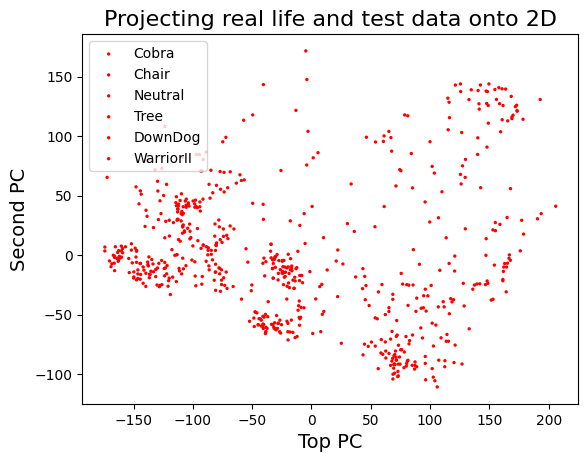

In [132]:
import matplotlib.pyplot as plt 

def plot_2d_projection(points, color, real):
    cords = [(extract_pca_2d(x[0]), x[1]) for x in points]

    class_labels = [point[1] for point in cords]

    unique_classes = set(class_labels)
    colors = {class_label: index for index, class_label in enumerate(unique_classes)}
    mat_colors = ['b', 'r', 'g', 'c', 'm', 'y']

    for class_label in unique_classes:
        x_v = [point[0][0][0] for idx, point in enumerate(cords) if class_labels[idx] == class_label]
        y_v = [point[0][0][1] for idx, point in enumerate(cords) if class_labels[idx] == class_label]

        c_ = [color for _ in range(len(x_v))]
        ax.scatter(x_v, y_v, c=c_, label=class_label, s=3)

fig, ax = plt.subplots()

plot_2d_projection(PCA_2D_POINTS, 'b', real=True)
combined_testing_data = [(X_test.iloc[i].to_list(), classes[y_test.iloc[i]]) for i in range(len(X_test))]
plot_2d_projection(combined_testing_data, 'r', real=False)

ax.legend()
plt.xlabel("Top PC", size=14)
plt.ylabel("Second PC", size=14)
plt.title('Projecting real life and test data onto 2D', size=16)
plt.show()
